In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import torchvision
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  
from torchvision.utils import save_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [17]:
@dataclass
class ModelArgs:
    device = 'cpu'
    batch_size = 1
    lr = 0.0002
    img_size = 128
    no_of_channels = 3
    kernel_size = (4,4)
    stride = 2
    # dropout = 0.5
    padding = 1
    lr_slope = 0.2
    # beta_1 = 0.5
    # beta_2 = 0.999
    no_of_kernel = 64
    lambda_gen = 10

In [6]:
ModelArgs.device = device

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02
        
    if classname.find('Conv2D') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02

In [27]:

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=ModelArgs.no_of_channels, out_channels=ModelArgs.no_of_kernel, kernel_size=(7,7), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=64, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=128, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=2, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device),
            nn.ReLU(),
            
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=2, device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=128, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=2, device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=64, device=ModelArgs.device),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=ModelArgs.no_of_channels, kernel_size=(7,7), stride=1, padding_mode='reflect', device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=ModelArgs.no_of_channels, device=ModelArgs.device),
            nn.ReLU(),
            
            
        )
    
    def forward(self, x):
        x = self.main(x)
        return x

In [28]:
#Intializing the Discriminator instance
Gen = Generator().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
Gen = Gen.apply(weights_init)
#Printing the structure
print(Gen)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding_mode=reflect)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding_mode=reflect)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding_mode=reflect)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding_mode=reflect)
    (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding_mode=reflect)
    (13): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (14): ReLU

In [29]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
gen = Generator()
summary(model=gen,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [1, 3, 128, 128]     [1, 3, 17, 17]       --                   True
├─Sequential (main)                      [1, 3, 128, 128]     [1, 3, 17, 17]       --                   True
│    └─Conv2d (0)                        [1, 3, 128, 128]     [1, 64, 122, 122]    9,472                True
│    └─InstanceNorm2d (1)                [1, 64, 122, 122]    [1, 64, 122, 122]    --                   --
│    └─ReLU (2)                          [1, 64, 122, 122]    [1, 64, 122, 122]    --                   --
│    └─Conv2d (3)                        [1, 64, 122, 122]    [1, 128, 60, 60]     73,856               True
│    └─InstanceNorm2d (4)                [1, 128, 60, 60]     [1, 128, 60, 60]     --                   --
│    └─ReLU (5)                          [1, 128, 60, 60]     [1, 128, 60, 60]     --                   --
│    └─Conv2d (6)     

In [46]:
class PatchGAN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
                
            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
               
            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
              
            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
            
            nn.Conv2d(512, 1, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),

            nn.Sigmoid()
            
        )
        
    def forward(self, x):
    
        return self.main(x)


In [25]:
#Intializing the Discriminator instance
patchgan = PatchGAN().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
patchgan = patchgan.apply(weights_init)
#Printing the structure
print(patchgan)

PatchGAN(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  )
)


In [26]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
patchgan = PatchGAN()
summary(model=patchgan,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchGAN (PatchGAN)                      [1, 3, 128, 128]     [1, 1, 14, 14]       --                   True
├─Sequential (main)                      [1, 3, 128, 128]     [1, 1, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 3, 128, 128]     [1, 64, 64, 64]      3,136                True
│    └─LeakyReLU (1)                     [1, 64, 64, 64]      [1, 64, 64, 64]      --                   --
│    └─Conv2d (2)                        [1, 64, 64, 64]      [1, 128, 32, 32]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 32, 32]     [1, 128, 32, 32]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 32, 32]     [1, 128, 32, 32]     --                   --
│    └─Conv2d (5)                        [1, 128, 32, 32]     [1, 256, 16, 16]     524,544              True
│    └─InstanceNor

In [36]:
#Config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


both_transform = A.Compose(
    [A.Resize(width=ModelArgs.img_size, height=ModelArgs.img_size),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        # A.ColorJitter(p=0.2),
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        # A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

In [37]:
import numpy as np
class Cityscapes2LabelsDataset(Dataset):
    
    def __init__(self, root_dir) -> None:
        super().__init__()
        self.train_path = root_dir
        self.dir = os.listdir(self.train_path)
        
    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, index):    
        
        current_img = self.dir[index]
        img_path = os.path.join(self.train_path, current_img) 
        img = np.array(Image.open(img_path))
        input = img[:, :256, :]
        mask = img[:, 256:, :]
        augmentataions = both_transform(image = input, image0 = mask)
        input = augmentataions['image']
        mask = augmentataions['image0']
        
        input_transformed = transform_only_input(image = input)['image']
        mask_transformed = transform_only_mask(image = mask)['image']
        
        return input_transformed, mask_transformed

In [38]:
#Creating dataloaders
dir = 'data/cityscapes/train'
train = Cityscapes2LabelsDataset(dir)
trainloader = DataLoader(train, batch_size=ModelArgs.batch_size, shuffle=True)
val_dir = 'data/cityscapes/val'
val = Cityscapes2LabelsDataset(val_dir)
valloader = DataLoader(val, batch_size=ModelArgs.batch_size, shuffle=False)


In [39]:
from pathlib  import Path
save_images = Path('generated_images/')
# enc = Encoder()

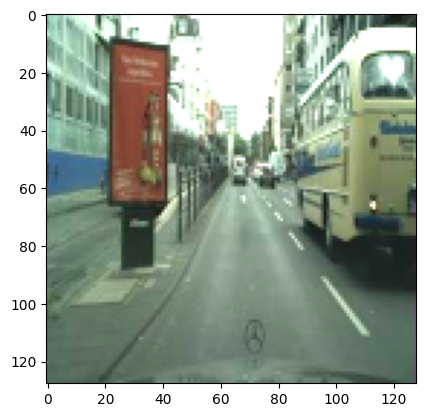

In [42]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in trainloader:
    imageX = X[0]
    # imagey = y[0]

    imageX = imageX.permute(1, 2, 0).numpy()
    # imagey = imagey.permute(1, 2, 0).numpy()
    # Plot the image
    plt.imshow(imageX)
    # plt.imshow(imagey)
    plt.show()
    plt.show()
    break


In [50]:
generatorX = Generator().to(ModelArgs.device).apply(weights_init)
discriminatorY = PatchGAN().to(ModelArgs.device).apply(weights_init)
generatorY = Generator().to(ModelArgs.device).apply(weights_init)
discriminatorX = PatchGAN().to(ModelArgs.device).apply(weights_init)


loss_fn = nn.MSELoss()  
epochs = 200 

generatorX.train()
discriminatorX.train()
generatorY.train()
discriminatorY.train()

optimizerG = torch.optim.Adam(list(generatorX.parameters()) + list(generatorY.parameters()), lr=ModelArgs.lr) #For discriminator
optimizerD = torch.optim.Adam(list(discriminatorY.parameters()) + list(discriminatorX.parameters()), lr=ModelArgs.lr) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []


In [ ]:
#Training loop

from tqdm import tqdm

iters = 0

writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

img_counter = 0
for epoch in tqdm(range(epochs)):

    for X, y in trainloader:

    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        if(img_counter > 50):
            img_counter = 0
            
        
        #############################
        # Discriminator Training
        #############################
        
        #Enabling the discriminators trainable ability 
        for params in discriminatorX.parameters():
            params.requires_grad_ = True            
            
        current_batch_size = X.shape[0]  #Getting the current batch size
        
        real_data = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        # 1. Forward pass
        y_pred = discriminatorX(X, X).mean(dim=[2,3]).squeeze(dim=1)
        # print(y_pred)
        # print(y_pred.shape)
        # 2. Calculate  and accumulate loss
        loss_real = loss_fn(y_pred, real_data)

        # 3. Optimizer zero grad
        optimizerD.zero_grad()

       
        # loss_real.backward()


        #Train the discriminator (with fake data)

        # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
        fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device, dtype=torch.float32)
        mask_generated_by_generatorY = generatorY(y)

        #1. Forward pass
        y_pred = discriminatorX(X,mask_generated_by_generatorY.detach()).mean(dim=[2,3]).squeeze(dim=1)


        # 2. Calculate  and accumulate loss
        loss_fake = loss_fn(y_pred, fake_data)


        #Accumulating total discriminator loss
        discriminatorX_combined_loss = (loss_real + loss_fake) 
        # loss_d.append(discriminator_combined_loss.item())

        
        
        #Enabling the discriminators trainable ability 
        for params in discriminatorY.parameters():
            params.requires_grad_ = True            
            
        current_batch_size = X.shape[0]  #Getting the current batch size
        
        real_data = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        # 1. Forward pass
        y_pred = discriminatorY(y, y).mean(dim=[2,3]).squeeze(dim=1)
        # print(y_pred)
        # print(y_pred.shape)
        
        # 2. Calculate  and accumulate loss
        loss_real = loss_fn(y_pred, real_data)


        #Train the discriminator (with fake data)

        # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
        fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device, dtype=torch.float32)
        mask_generated_by_generatorX = generatorX(X)

        #1. Forward pass
        y_pred = discriminatorY(y,mask_generated_by_generatorX.detach()).mean(dim=[2,3]).squeeze(dim=1)


        # 2. Calculate  and accumulate loss
        loss_fake = loss_fn(y_pred, fake_data)
        
        
        discriminatorY_combined_loss = (loss_real + loss_fake) 
        
        discriminator_combined_loss = (discriminatorX_combined_loss + discriminatorY_combined_loss) * 0.5
        
        
        # 4. Loss backward
        discriminator_combined_loss.backward()
        
         # 5. Optimizer step
        optimizerD.step()
        

        ###########################
        # Generator Training
        ##########################

         #Disabling the discriminators trainable ability 
        for params in discriminatorX.parameters():
            params.requires_grad_ = False
            
        # mask_generated_by_generator = unet(X)
        labels = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        #1. Forward pass
        y_pred = discriminatorX(X, mask_generated_by_generatorY).mean(dim=[2,3]).squeeze(dim=1)
        # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


        #2. Calculate and accumulate loss
        loss_geny = loss_fn(y_pred,labels) 
        
        
        #Disabling the discriminators trainable ability 
        for params in discriminatorY.parameters():
            params.requires_grad_ = False
            
        # mask_generated_by_generator = unet(X)
        labels = torch.ones((current_batch_size,), device=ModelArgs.device, dtype=torch.float32)

        #1. Forward pass
        y_pred = discriminatorY(y, mask_generated_by_generatorX).mean(dim=[2,3]).squeeze(dim=1)
        # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


        #2. Calculate and accumulate loss
        loss_genx = loss_fn(y_pred,labels) 
        
        combined_generator_loss = loss_geny + loss_genx

        # 3. Optimizer zero grad
        optimizerG.zero_grad()

        # 4. Loss backward
        combined_generator_loss.backward()

        # 5. Optimizer step
        optimizerG.step()
        
        
        
        

        if iters % 500 == 0:
            print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", combined_generator_loss.item(), "Discriminator loss: ", discriminator_combined_loss.item())

    
        if iters % 500 == 0:
            
            print('saving the output')
            torchvision.utils.save_image(y,'{}/real_images_iters_{}.png'.format(save_images, iters),normalize=True)
            fake = generatorX(X)
            torchvision.utils.save_image(fake,'{}/fake_images_iters_{}.png'.format(save_images, iters),normalize=True)

            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(y, normalize=True)
            # img_grid_map = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Cityscapes2lables Fake Images", img_grid_fake, global_step=iters
                    )
            writer_real.add_image(
                        "Cityscapes2lables Mask Images", img_grid_real, global_step=iters
                    )
            
            # writer_real.add_image(
            #             "Map2Aerial Aerial Images", img_grid_map, global_step=iters
            #         )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1
